###### Forecst Store Sales using a Kaggle Dataset
https://www.kaggle.com/competitions/store-sales-time-series-forecasting/overview

# Import Libraries and load the data

In [474]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from prophet import Prophet
from sklearn.metrics import mean_squared_log_error
#from sklearn.metrics import mean_squared_error

In [499]:
# load all the data files into dataframes

df_train = pd.read_csv('data/train.csv',index_col='id', parse_dates = ['date'], infer_datetime_format = True)
df_test = pd.read_csv('data/test.csv',index_col='id', parse_dates = ['date'], infer_datetime_format = True)
df_holidays = pd.read_csv('data/holidays_events.csv', parse_dates = ['date'], infer_datetime_format = True)
df_oil = pd.read_csv('data/oil.csv',  parse_dates = ['date'], infer_datetime_format = True)
df_sample_submission = pd.read_csv('data/sample_submission.csv',index_col='id')
df_stores = pd.read_csv('data/stores.csv')
df_transactions = pd.read_csv('data/transactions.csv',  parse_dates = ['date'], infer_datetime_format = True)

## Profile training data frame

In [476]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3000888 entries, 0 to 3000887
Data columns (total 5 columns):
 #   Column       Dtype         
---  ------       -----         
 0   date         datetime64[ns]
 1   store_nbr    int64         
 2   family       object        
 3   sales        float64       
 4   onpromotion  int64         
dtypes: datetime64[ns](1), float64(1), int64(2), object(1)
memory usage: 137.4+ MB


In [477]:
df_train.sample(20)

,date,store_nbr,family,sales,onpromotion
id,,,,,
2635952,2017-01-23,2,FROZEN FOODS,103.97,3
1971193,2016-01-15,18,BOOKS,0.00,0
839418,2014-04-18,11,PRODUCE,0.00,0
550213,2013-11-05,47,BOOKS,0.00,0
434383,2013-09-01,47,BOOKS,0.00,0
1264873,2014-12-12,49,HOME AND KITCHEN II,13.00,0
200940,2013-04-23,47,BEVERAGES,1904.00,0
2737409,2017-03-21,16,PET SUPPLIES,0.00,0
2731206,2017-03-17,41,PLAYERS AND ELECTRONICS,4.00,0


In [478]:
#aggregate sales at the daily level to check trends
aggr_sales = pd.DataFrame(df_train.groupby('date').agg({'sales': 'sum'}))
pd.options.display.float_format = '{:.2f}'.format
aggr_sales.describe()

,sales
count,1684.00
mean,637556.38
std,234410.24
min,2511.62
25%,442711.49
50%,632188.86
75%,785945.48
max,1463083.96


Text(0.5, 1.0, 'Trend of Overall Sales')

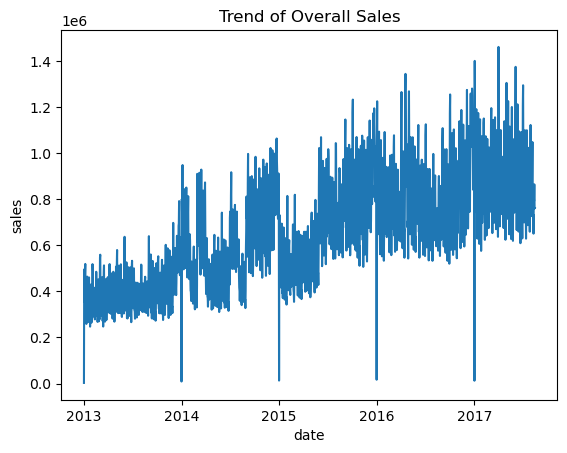

In [479]:
sns.lineplot(data=df_train.groupby('date').agg({'sales': 'sum'}),  x='date', y='sales').set_title('Trend of Overall Sales')

In [480]:
aggr_sales.loc[['2013-01-01', '2014-01-01', '2015-01-01', '2016-01-01', '2017-01-01']]

,sales
date,
2013-01-01,2511.62
2014-01-01,8602.07
2015-01-01,12773.62
2016-01-01,16433.39
2017-01-01,12082.50


### findings
* 1st day of the year has low sales
* general trends was up but now seems to be stables
* there is huge differnce in the sales range 
* there are instances where sales is 0 for a store and family combination

## Profile holidays data frame

Notes from Kaggle for Holidays and Events, with metadata
NOTE: 

Pay special attention to the transferred column. A holiday that is transferred officially falls on that calendar day, but was moved to another date by the government. A transferred day is more like a normal day than a holiday. To find the day that it was actually celebrated, look for the corresponding row where type is Transfer. For example, the holiday Independencia de Guayaquil was transferred from 2012-10-09 to 2012-10-12, which means it was celebrated on 2012-10-12. 

Days that are type Bridge are extra days that are added to a holiday (e.g., to extend the break across a long weekend). These are frequently made up by the type Work Day which is a day not normally scheduled for work (e.g., Saturday) that is meant to payback the Bridge.

Additional holidays are days added a regular calendar holiday, for example, as typically happens around Christmas (making Christmas Eve a holiday).

In [481]:
df_holidays.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350 entries, 0 to 349
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         350 non-null    datetime64[ns]
 1   type         350 non-null    object        
 2   locale       350 non-null    object        
 3   locale_name  350 non-null    object        
 4   description  350 non-null    object        
 5   transferred  350 non-null    bool          
dtypes: bool(1), datetime64[ns](1), object(4)
memory usage: 14.1+ KB


In [482]:
df_holidays.sample(25)

,date,type,locale,locale_name,description,transferred
68,2013-08-15,Holiday,Local,Riobamba,Fundacion de Riobamba,False
151,2014-12-22,Holiday,Local,Salinas,Cantonizacion de Salinas,False
122,2014-07-08,Event,National,Ecuador,Mundial de futbol Brasil: Semifinales,False
53,2013-05-11,Additional,National,Ecuador,Dia de la Madre-1,False
233,2016-04-29,Event,National,Ecuador,Terremoto Manabi+13,False
212,2016-02-08,Holiday,National,Ecuador,Carnaval,False
71,2013-10-07,Holiday,Local,Quevedo,Cantonizacion de Quevedo,False
166,2015-04-03,Holiday,National,Ecuador,Viernes Santo,False
201,2015-12-06,Holiday,Local,Quito,Fundacion de Quito,False
100,2014-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


## Profile Stores dataframe
Store metadata, including city, state, type, and cluster.
cluster is a grouping of similar stores

In [483]:
df_stores.sample(25)

,store_nbr,city,state,type,cluster
31,32,Guayaquil,Guayas,C,3
39,40,Machala,El Oro,C,3
34,35,Playas,Guayas,C,3
16,17,Quito,Pichincha,C,12
43,44,Quito,Pichincha,A,5
6,7,Quito,Pichincha,D,8
47,48,Quito,Pichincha,A,14
26,27,Daule,Guayas,D,1
48,49,Quito,Pichincha,A,11
9,10,Quito,Pichincha,C,15


Text(0.5, 1.0, 'Number of Stores by Type and Cluster')

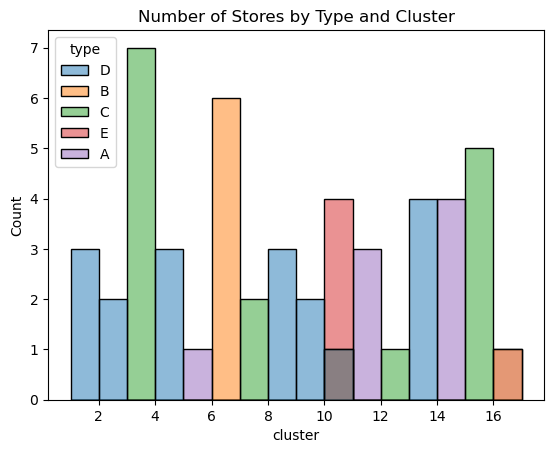

In [351]:
sns.histplot(data = df_stores
            , x='cluster'
            , hue='type'
            ,binwidth = 1).set_title('Number of Stores by Type and Cluster')

### Findings
* Store type and Store Cluster seem to be providing similar information. Only Cluster 10 has 2 different types of stores in it

## Profile the oil datframe
Daily oil price. Includes values during both the train and test data timeframes. (Ecuador is an oil-dependent country and it's economical health is highly vulnerable to shocks in oil prices.)

In [484]:
df_oil.head(20)

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20
5,2013-01-08,93.21
6,2013-01-09,93.08
7,2013-01-10,93.81
8,2013-01-11,93.60
9,2013-01-14,94.27


In [8]:
df_oil.tail(20)

,date,dcoilwtico
1198,2017-08-04,49.57
1199,2017-08-07,49.37
1200,2017-08-08,49.07
1201,2017-08-09,49.59
1202,2017-08-10,48.54
1203,2017-08-11,48.81
1204,2017-08-14,47.59
1205,2017-08-15,47.57
1206,2017-08-16,46.80
1207,2017-08-17,47.07


In [485]:
# find null values
df_oil[df_oil['dcoilwtico'].isnull()].count()

date          43
dcoilwtico     0
dtype: int64

Text(0.5, 1.0, 'Trend of Oil Prices')

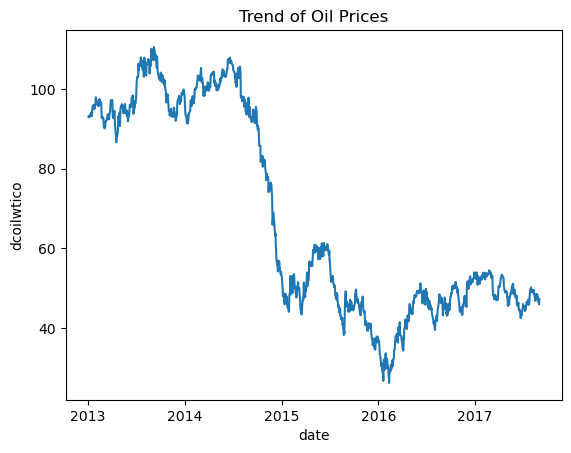

In [486]:
sns.lineplot(data=df_oil,  x='date', y='dcoilwtico').set_title('Trend of Oil Prices')

### Findings
* The datasets starts with 0 and there are several missing values
* There is a step function drop arund 2015 and several peaks and drops in the dataset
* The time series has missing dates as well




# Profile the transactions dataset

In [354]:
df_transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83488 entries, 0 to 83487
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          83488 non-null  datetime64[ns]
 1   store_nbr     83488 non-null  int64         
 2   transactions  83488 non-null  int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 1.9 MB


In [355]:
df_transactions.head(15)

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922
5,2013-01-02,5,1903
6,2013-01-02,6,2143
7,2013-01-02,7,1874
8,2013-01-02,8,3250
9,2013-01-02,9,2940


In [356]:
df_transactions.tail(5)

,date,store_nbr,transactions
83483,2017-08-15,50,2804
83484,2017-08-15,51,1573
83485,2017-08-15,52,2255
83486,2017-08-15,53,932
83487,2017-08-15,54,802


In [358]:
df_transactions.store_nbr.unique()

array([25,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 23, 24, 26, 27, 28, 30, 31, 32, 33, 34, 35, 37, 38, 39,
       40, 41, 43, 44, 45, 46, 47, 48, 49, 50, 51, 54, 36, 53, 20, 29, 21,
       42, 22, 52])

### Findings
* this dataset is only for training and does not have test data

## Profile Test data frame

In [361]:
df_test.head()

,date,store_nbr,family,onpromotion
id,,,,
3000888,2017-08-16,1,AUTOMOTIVE,0
3000889,2017-08-16,1,BABY CARE,0
3000890,2017-08-16,1,BEAUTY,2
3000891,2017-08-16,1,BEVERAGES,20
3000892,2017-08-16,1,BOOKS,0


In [362]:
df_test.tail()

,date,store_nbr,family,onpromotion
id,,,,
3029395,2017-08-31,9,POULTRY,1
3029396,2017-08-31,9,PREPARED FOODS,0
3029397,2017-08-31,9,PRODUCE,1
3029398,2017-08-31,9,SCHOOL AND OFFICE SUPPLIES,9
3029399,2017-08-31,9,SEAFOOD,0


In [363]:
df_test.store_nbr.unique()

array([ 1, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,  2, 20, 21, 22, 23, 24,
       25, 26, 27, 28, 29,  3, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39,  4,
       40, 41, 42, 43, 44, 45, 46, 47, 48, 49,  5, 50, 51, 52, 53, 54,  6,
        7,  8,  9])

## Feature Engineering and creating the final Train and Test datasets
* Add store location and Cluster/Type data to test and train dataset
* Holiday dataset so that it is an additional regressor at the store and region level
* Oil dataset so that it is an additional regressor
* Store dataset to get stores in same regons that might be running promotions that impact sales
* Wages in the public sector are paid every two weeks on the 15 th and on the last day of the month. Supermarket sales could be affected by this
* A magnitude 7.8 earthquake struck Ecuador on April 16, 2016. People rallied in relief efforts donating water and other first need products which greatly affected supermarket sales for several weeks after the earthquake

### Add store location and cluster data to train and test
* This will be used to add regional and local holidays
* This will also be used to add items that are on promo in nearby stores

In [500]:
df_train = pd.merge(df_train,df_stores , how="left", on="store_nbr").copy()
df_test = pd.merge(df_test,df_stores , how="left", on="store_nbr").copy()

In [501]:
df_train

,date,store_nbr,family,sales,onpromotion,city,state,type,cluster
0,2013-01-01,1,AUTOMOTIVE,0.00,0,Quito,Pichincha,D,13
1,2013-01-01,1,BABY CARE,0.00,0,Quito,Pichincha,D,13
2,2013-01-01,1,BEAUTY,0.00,0,Quito,Pichincha,D,13
3,2013-01-01,1,BEVERAGES,0.00,0,Quito,Pichincha,D,13
4,2013-01-01,1,BOOKS,0.00,0,Quito,Pichincha,D,13
...,...,...,...,...,...,...,...,...,...
3000883,2017-08-15,9,POULTRY,438.13,0,Quito,Pichincha,B,6
3000884,2017-08-15,9,PREPARED FOODS,154.55,1,Quito,Pichincha,B,6
3000885,2017-08-15,9,PRODUCE,2419.73,148,Quito,Pichincha,B,6
3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.00,8,Quito,Pichincha,B,6


### Feature engineering on the holidays

Notes from Kaggle for Holidays and Events, with metadata
NOTE: 

Pay special attention to the transferred column. A holiday that is transferred officially falls on that calendar day, but was moved to another date by the government. A transferred day is more like a normal day than a holiday. To find the day that it was actually celebrated, look for the corresponding row where type is Transfer. For example, the holiday Independencia de Guayaquil was transferred from 2012-10-09 to 2012-10-12, which means it was celebrated on 2012-10-12. 

Days that are type Bridge are extra days that are added to a holiday (e.g., to extend the break across a long weekend). These are frequently made up by the type Work Day which is a day not normally scheduled for work (e.g., Saturday) that is meant to payback the Bridge.

Additional holidays are days added a regular calendar holiday, for example, as typically happens around Christmas (making Christmas Eve a holiday).

In [502]:
#remove holidays that were transferred
df_holiday_clean = df_holidays.query('transferred!=True').copy()
df_holiday_clean.sample(20)

,date,type,locale,locale_name,description,transferred
196,2015-11-11,Holiday,Local,Latacunga,Independencia de Latacunga,False
121,2014-07-05,Event,National,Ecuador,Mundial de futbol Brasil: Cuartos de Final,False
73,2013-10-11,Transfer,National,Ecuador,Traslado Independencia de Guayaquil,False
181,2015-07-23,Holiday,Local,Cayambe,Cantonizacion de Cayambe,False
299,2017-02-27,Holiday,National,Ecuador,Carnaval,False
17,2012-09-28,Holiday,Local,Ibarra,Fundacion de Ibarra,False
174,2015-05-24,Holiday,National,Ecuador,Batalla de Pichincha,False
125,2014-07-13,Event,National,Ecuador,Mundial de futbol Brasil: Final,False
146,2014-12-05,Additional,Local,Quito,Fundacion de Quito-1,False
298,2017-01-02,Transfer,National,Ecuador,Traslado Primer dia del ano,False


In [503]:
# national holidays, additional days and events
df_national_holiday = df_holiday_clean.query("locale=='National' and type!='Work Day'")[['date']].copy()
df_national_holiday["national_holiday_ind"] = 1
df_national_holiday

,date,national_holiday_ind
14,2012-08-10,1
20,2012-10-12,1
21,2012-11-02,1
22,2012-11-03,1
31,2012-12-21,1
...,...,...
345,2017-12-22,1
346,2017-12-23,1
347,2017-12-24,1
348,2017-12-25,1


In [504]:
# add national holiday data to the test and train dataset
df_train = df_train.drop('national_holiday_ind', axis=1, errors='ignore')
df_test = df_test.drop('national_holiday_ind', axis=1, errors='ignore')


df_train = pd.merge(df_train,df_national_holiday , how="left", on="date").copy()
df_test = pd.merge(df_test,df_national_holiday , how="left", on="date").copy()

df_train['national_holiday_ind'].fillna(0, inplace=True)
df_test['national_holiday_ind'].fillna(0, inplace=True)

df_train.sample(25)

,date,store_nbr,family,sales,onpromotion,city,state,type,cluster,national_holiday_ind
1852401,2015-11-07,34,GROCERY I,3881.18,6,Guayaquil,Guayas,B,6,0.00
779095,2014-03-15,19,SCHOOL AND OFFICE SUPPLIES,0.00,0,Guaranda,Bolivar,C,15,0.00
3003875,2017-08-13,42,HOME APPLIANCES,0.00,0,Cuenca,Azuay,D,2,0.00
2237757,2016-06-08,46,PLAYERS AND ELECTRONICS,3.00,0,Quito,Pichincha,A,14,0.00
2449893,2016-10-05,49,CELEBRATION,25.00,0,Quito,Pichincha,A,11,0.00
1022075,2014-07-29,36,SEAFOOD,0.00,0,Libertad,Guayas,E,10,0.00
1625520,2015-07-03,19,CELEBRATION,10.00,0,Guaranda,Bolivar,C,15,0.00
32445,2013-01-19,2,CELEBRATION,0.00,0,Quito,Pichincha,D,13,0.00
3875,2013-01-03,18,HARDWARE,0.00,0,Quito,Pichincha,B,16,0.00
1989205,2016-01-24,22,SCHOOL AND OFFICE SUPPLIES,1.00,0,Puyo,Pastaza,C,7,0.00


In [505]:
#regional holidays
df_regional_holiday = df_holiday_clean.query("locale=='Regional' and type!='Work Day'")[['date','locale_name']].copy()
df_regional_holiday["regional_holiday_ind"] = 1
df_regional_holiday.sample(10)

,date,locale_name,regional_holiday_ind
278,2016-11-06,Santo Domingo de los Tsachilas,1
279,2016-11-07,Santa Elena,1
139,2014-11-06,Santo Domingo de los Tsachilas,1
47,2013-04-01,Cotopaxi,1
140,2014-11-07,Santa Elena,1
7,2012-06-25,Imbabura,1
334,2017-11-06,Santo Domingo de los Tsachilas,1
77,2013-11-07,Santa Elena,1
216,2016-04-01,Cotopaxi,1
1,2012-04-01,Cotopaxi,1


In [506]:
df_train = df_train.drop('regional_holiday_ind', axis=1, errors='ignore')
df_test = df_test.drop('regional_holiday_ind', axis=1, errors='ignore')


df_train = pd.merge(df_train,df_regional_holiday , how="left", left_on=["date", "state"] 
                    ,right_on=["date", "locale_name"]).copy()
df_test = pd.merge(df_test,df_regional_holiday , how="left", left_on=["date", "state"]   
                   ,right_on=["date", "locale_name"] ).copy()

df_train['regional_holiday_ind'].fillna(0, inplace=True)
df_test['regional_holiday_ind'].fillna(0, inplace=True)

In [507]:
df_test.drop('locale_name', axis=1, inplace=True)
df_train.drop('locale_name', axis=1,inplace=True)


df_test.sample(25)

,date,store_nbr,family,onpromotion,city,state,type,cluster,national_holiday_ind,regional_holiday_ind
25189,2017-08-30,16,EGGS,11,Santo Domingo,Santo Domingo de los Tsachilas,C,3,0.00,0.00
26393,2017-08-30,49,PET SUPPLIES,0,Quito,Pichincha,A,11,0.00,0.00
7303,2017-08-20,14,EGGS,1,Riobamba,Chimborazo,C,7,0.00,0.00
19245,2017-08-26,49,CELEBRATION,0,Quito,Pichincha,A,11,0.00,0.00
11008,2017-08-22,18,LADIESWEAR,0,Quito,Pichincha,B,16,0.00,0.00
23212,2017-08-29,10,GROCERY II,0,Quito,Pichincha,C,15,0.00,0.00
4027,2017-08-18,22,BABY CARE,0,Puyo,Pastaza,C,7,0.00,0.00
1066,2017-08-16,39,EGGS,1,Cuenca,Azuay,B,6,0.00,0.00
23701,2017-08-29,24,CLEANING,12,Guayaquil,Guayas,D,1,0.00,0.00
25925,2017-08-30,36,LAWN AND GARDEN,8,Libertad,Guayas,E,10,0.00,0.00


In [508]:
#local holidays
df_local_holiday = df_holiday_clean.query("locale=='Local' and type!='Work Day'")[['date','locale_name']].copy()
df_local_holiday["local_holiday_ind"] = 1

df_local_holiday.sample(10)

,date,locale_name,local_holiday_ind
197,2015-11-12,Ambato,1
201,2015-12-06,Quito,1
79,2013-11-11,Latacunga,1
69,2013-08-24,Ambato,1
10,2012-07-03,Santo Domingo,1
118,2014-07-03,El Carmen,1
169,2015-04-21,Riobamba,1
184,2015-08-05,Esmeraldas,1
262,2016-07-03,Santo Domingo,1
187,2015-08-24,Ambato,1


In [509]:
# add local holidays to the datasets
df_train = df_train.drop('local_holiday_ind', axis=1, errors='ignore')
df_test = df_test.drop('local_holiday_ind', axis=1, errors='ignore')


df_train = pd.merge(df_train,df_local_holiday , how="left", left_on=["date", "city"] 
                    ,right_on=["date", "locale_name"]).copy()
df_test = pd.merge(df_test,df_local_holiday , how="left", left_on=["date", "city"]   
                   ,right_on=["date", "locale_name"] ).copy()

df_train['local_holiday_ind'].fillna(0, inplace=True)
df_test['local_holiday_ind'].fillna(0, inplace=True)

In [510]:
df_test.drop('locale_name', axis=1, inplace=True)
df_train.drop('locale_name', axis=1,inplace=True)


df_train.sample(25)

,date,store_nbr,family,sales,onpromotion,city,state,type,cluster,national_holiday_ind,regional_holiday_ind,local_holiday_ind
2002297,2016-01-31,4,"LIQUOR,WINE,BEER",0.00,0,Quito,Pichincha,D,9,0.00,0.00,0.00
1668092,2015-07-27,13,DAIRY,239.00,0,Latacunga,Cotopaxi,C,15,0.00,0.00,0.00
1786108,2015-10-01,24,HOME AND KITCHEN II,47.00,0,Guayaquil,Guayas,D,1,0.00,0.00,0.00
1531005,2015-05-11,17,BEVERAGES,1648.00,0,Quito,Pichincha,C,12,0.00,0.00,0.00
1099103,2014-09-10,48,BREAD/BAKERY,511.43,1,Quito,Pichincha,A,14,0.00,0.00,0.00
422910,2013-08-26,25,HOME AND KITCHEN I,0.00,0,Salinas,Santa Elena,D,1,0.00,0.00,0.00
365605,2013-07-25,17,SCHOOL AND OFFICE SUPPLIES,0.00,0,Quito,Pichincha,C,12,0.00,0.00,0.00
2819434,2017-05-02,10,GROCERY II,5.00,0,Quito,Pichincha,C,15,0.00,0.00,0.00
1276218,2014-12-19,18,DELI,147.88,0,Quito,Pichincha,B,16,0.00,0.00,0.00
752285,2014-02-28,17,HOME APPLIANCES,0.00,0,Quito,Pichincha,C,12,0.00,0.00,0.00


### A magnitude 7.8 earthquake struck Ecuador on April 16, 2016

In [511]:
print(df_holidays[df_holidays['date'] == '2016-04-16'])
#df_train['national_holiday_ind'].mask(df_train['date'] == '2016-04-16', 5, inplace=True)

          date   type    locale locale_name       description  transferred
219 2016-04-16  Event  National     Ecuador  Terremoto Manabi        False


### Feature engineering on the oil dataset
* Filling missing values and added it to the test and train dataset
* adding missing dates to the dataset

In [512]:
# create a time series dataframe from start to an additional 15 days that need to be forecasted
oil_ts = pd.DataFrame(pd.date_range(start='2013-01-01' , end='2017-08-31') , columns=['date'])

In [513]:
# merge the oil data into the new dataframe so that there are no missing dates
oil_ts = pd.merge(oil_ts,df_oil , how="left", on="date").copy()

In [514]:
oil_ts.head(20)

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-05,NaN
5,2013-01-06,NaN
6,2013-01-07,93.20
7,2013-01-08,93.21
8,2013-01-09,93.08
9,2013-01-10,93.81


In [515]:
oil_ts.tail(20)

,date,dcoilwtico
1684,2017-08-12,NaN
1685,2017-08-13,NaN
1686,2017-08-14,47.59
1687,2017-08-15,47.57
1688,2017-08-16,46.80
1689,2017-08-17,47.07
1690,2017-08-18,48.59
1691,2017-08-19,NaN
1692,2017-08-20,NaN
1693,2017-08-21,47.39


In [516]:
# fill the oil data that is missing with the next non missing value
oil_ts['dcoilwtico'].fillna(method='backfill', inplace=True)

In [517]:
oil_ts[oil_ts['dcoilwtico'].isnull()]

,date,dcoilwtico


In [518]:
# add oil data to the test and train dataset
df_train = df_train.drop('dcoilwtico', axis=1, errors='ignore')
df_test = df_test.drop('dcoilwtico', axis=1, errors='ignore')


df_train = pd.merge(df_train,oil_ts , how="left", on="date").copy()
df_test = pd.merge(df_test,oil_ts , how="left", on="date").copy()
df_train.head()

,date,store_nbr,family,sales,onpromotion,city,state,type,cluster,national_holiday_ind,regional_holiday_ind,local_holiday_ind,dcoilwtico
0,2013-01-01,1,AUTOMOTIVE,0.00,0,Quito,Pichincha,D,13,1.00,0.00,0.00,93.14
1,2013-01-01,1,BABY CARE,0.00,0,Quito,Pichincha,D,13,1.00,0.00,0.00,93.14
2,2013-01-01,1,BEAUTY,0.00,0,Quito,Pichincha,D,13,1.00,0.00,0.00,93.14
3,2013-01-01,1,BEVERAGES,0.00,0,Quito,Pichincha,D,13,1.00,0.00,0.00,93.14
4,2013-01-01,1,BOOKS,0.00,0,Quito,Pichincha,D,13,1.00,0.00,0.00,93.14


### Create a dataset that has indicators for dates when wages are paid

In [519]:
#create the wages dataset
wages_ts = pd.DataFrame(pd.date_range(start='2013-01-01' , end='2017-08-31') , columns=['date'])

In [520]:
#indicator for 15th and last day of each month

wages_ts = wages_ts.drop('is_salary_day', axis=1, errors='ignore')

def wage_dates(col):
    if col['date'].is_month_end or col['date'].day==15:
        return 1
    else:
        return 0

wages_ts['is_salary_day'] = wages_ts.apply(wage_dates, axis=1)

wages_ts.head(20)

,date,is_salary_day
0,2013-01-01,0
1,2013-01-02,0
2,2013-01-03,0
3,2013-01-04,0
4,2013-01-05,0
5,2013-01-06,0
6,2013-01-07,0
7,2013-01-08,0
8,2013-01-09,0
9,2013-01-10,0


In [521]:
# add wage days to the train and test dataset
df_train = df_train.drop('is_salary_day', axis=1, errors='ignore')
df_train = pd.merge(df_train,wages_ts , how="left", on="date").copy()

df_test = df_test.drop('is_salary_day', axis=1, errors='ignore')
df_test = pd.merge(df_test,wages_ts , how="left", on="date").copy()

In [522]:
df_train.head()

,date,store_nbr,family,sales,onpromotion,city,state,type,cluster,national_holiday_ind,regional_holiday_ind,local_holiday_ind,dcoilwtico,is_salary_day
0,2013-01-01,1,AUTOMOTIVE,0.00,0,Quito,Pichincha,D,13,1.00,0.00,0.00,93.14,0
1,2013-01-01,1,BABY CARE,0.00,0,Quito,Pichincha,D,13,1.00,0.00,0.00,93.14,0
2,2013-01-01,1,BEAUTY,0.00,0,Quito,Pichincha,D,13,1.00,0.00,0.00,93.14,0
3,2013-01-01,1,BEVERAGES,0.00,0,Quito,Pichincha,D,13,1.00,0.00,0.00,93.14,0
4,2013-01-01,1,BOOKS,0.00,0,Quito,Pichincha,D,13,1.00,0.00,0.00,93.14,0


## Train the Prophet model for a single store and family to build framework

In [523]:
#creaate a copy and check the data types
df_train_p = pd.DataFrame()
df_train_p = df_train.query("store_nbr == 9 and family == 'BEVERAGES' ").copy(deep=True)
df_train_p.dtypes

date                    datetime64[ns]
store_nbr                        int64
family                          object
sales                          float64
onpromotion                      int64
city                            object
state                           object
type                            object
cluster                          int64
national_holiday_ind           float64
regional_holiday_ind           float64
local_holiday_ind              float64
dcoilwtico                     float64
is_salary_day                    int64
dtype: object

In [524]:
#rename the columns
df_train_p.rename(columns={'date':'ds','sales':'y'}, inplace=True)

In [525]:
df_train_p.y = np.log1p(df_train_p.y)

In [526]:
df_train_p.head()

,ds,store_nbr,family,y,onpromotion,city,state,type,cluster,national_holiday_ind,regional_holiday_ind,local_holiday_ind,dcoilwtico,is_salary_day
1752,2013-01-01,9,BEVERAGES,0.00,0,Quito,Pichincha,B,6,1.00,0.00,0.00,93.14,0
3534,2013-01-02,9,BEVERAGES,7.18,0,Quito,Pichincha,B,6,0.00,0.00,0.00,93.14,0
5316,2013-01-03,9,BEVERAGES,6.95,0,Quito,Pichincha,B,6,0.00,0.00,0.00,92.97,0
7098,2013-01-04,9,BEVERAGES,6.89,0,Quito,Pichincha,B,6,0.00,0.00,0.00,93.12,0
8880,2013-01-05,9,BEVERAGES,7.26,0,Quito,Pichincha,B,6,0.00,0.00,0.00,93.20,0


In [527]:
#train the model
model = Prophet()
model.add_regressor('dcoilwtico')
model.add_regressor('is_salary_day')
model.add_regressor('onpromotion')
model.add_regressor('national_holiday_ind')
model.add_regressor('regional_holiday_ind')
model.add_regressor('local_holiday_ind')


model.fit(df_train_p)
model

10:32:32 - cmdstanpy - INFO - Chain [1] start processing
10:32:33 - cmdstanpy - INFO - Chain [1] done processing


In [528]:
#make predictions on the train data
preds = model.predict(df_train_p)
preds.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,dcoilwtico,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
1683,2017-08-11,8.18,7.08,8.34,8.18,8.18,-0.42,-0.42,-0.42,-0.11,...,-0.24,-0.24,-0.24,-0.16,-0.16,-0.16,0.00,0.00,0.00,7.76
1684,2017-08-12,8.18,7.68,8.94,8.18,8.18,0.14,0.14,0.14,-0.12,...,0.30,0.30,0.30,-0.16,-0.16,-0.16,0.00,0.00,0.00,8.33
1685,2017-08-13,8.18,7.85,9.15,8.18,8.18,0.33,0.33,0.33,-0.12,...,0.45,0.45,0.45,-0.16,-0.16,-0.16,0.00,0.00,0.00,8.51
1686,2017-08-14,8.18,7.41,8.69,8.18,8.18,-0.11,-0.11,-0.11,-0.12,...,0.03,0.03,0.03,-0.15,-0.15,-0.15,0.00,0.00,0.00,8.07
1687,2017-08-15,8.18,7.37,8.62,8.18,8.18,-0.18,-0.18,-0.18,-0.12,...,-0.09,-0.09,-0.09,-0.15,-0.15,-0.15,0.00,0.00,0.00,8.00


In [529]:
final_df= pd.concat([preds.set_index('ds'),df_train_p.set_index('ds')], axis=1, join='outer').reset_index()
final_df[['ds','y','yhat']].tail(20)

,ds,y,yhat
1668,2017-07-27,7.72,8.02
1669,2017-07-28,8.02,8.00
1670,2017-07-29,8.44,8.54
1671,2017-07-30,8.54,8.69
1672,2017-07-31,8.26,8.24
1673,2017-08-01,8.48,8.05
1674,2017-08-02,8.23,7.92
1675,2017-08-03,8.28,7.90
1676,2017-08-04,8.11,7.86
1677,2017-08-05,8.38,8.38


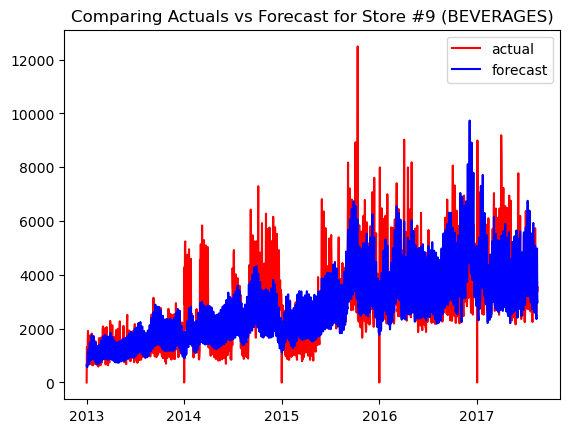

In [532]:
plt.plot(final_df['ds'] , np.expm1(final_df['y']), color='red' , label='actual')
plt.plot(final_df['ds'] , np.expm1(final_df['yhat']), color='blue' , label='forecast')
plt.title('Comparing Actuals vs Forecast for Store #9 (BEVERAGES)')
plt.legend()

In [533]:
train_preds = final_df.query("ds<='2017-08-15'")
msle = mean_squared_log_error(np.expm1(train_preds[['y']]) , np.expm1(train_preds[['yhat']]))
print("MSLE is ", msle)                                          

MSLE is  0.24595533461468866


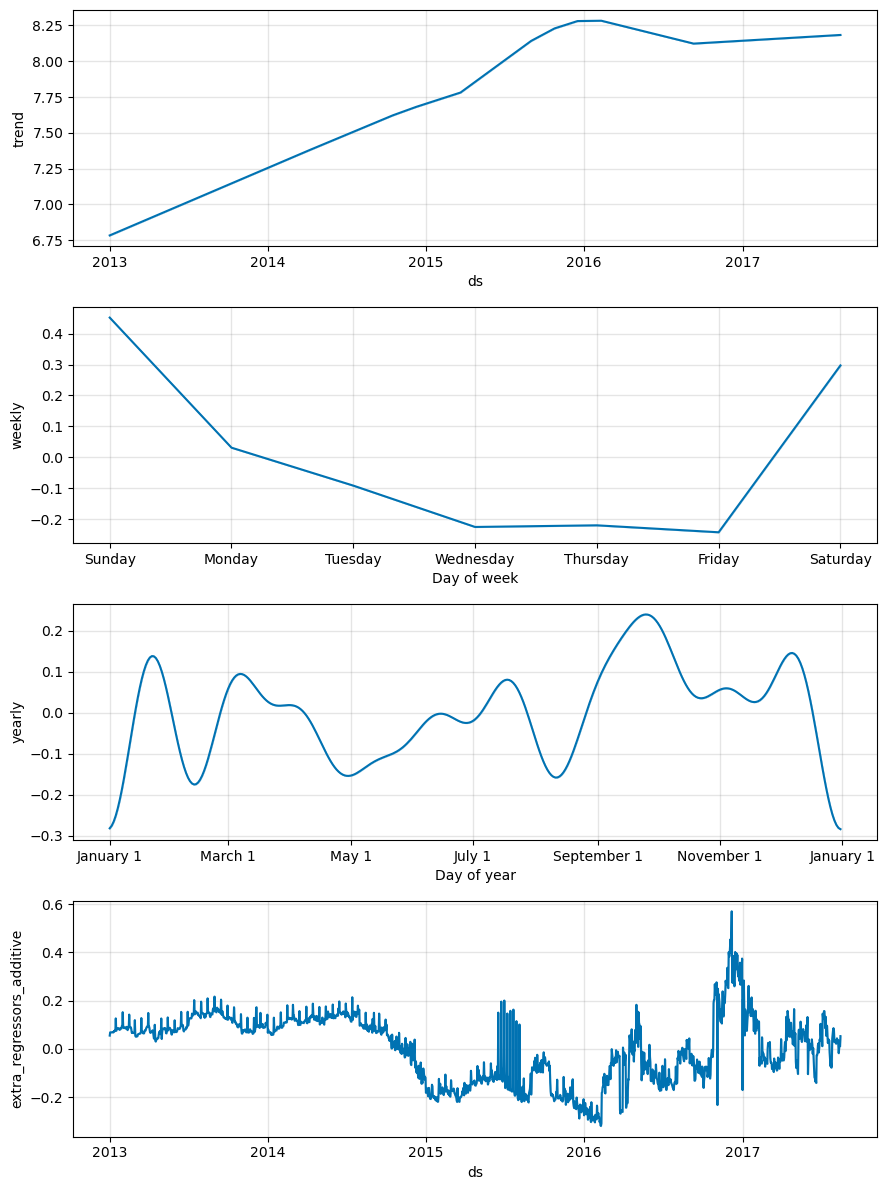

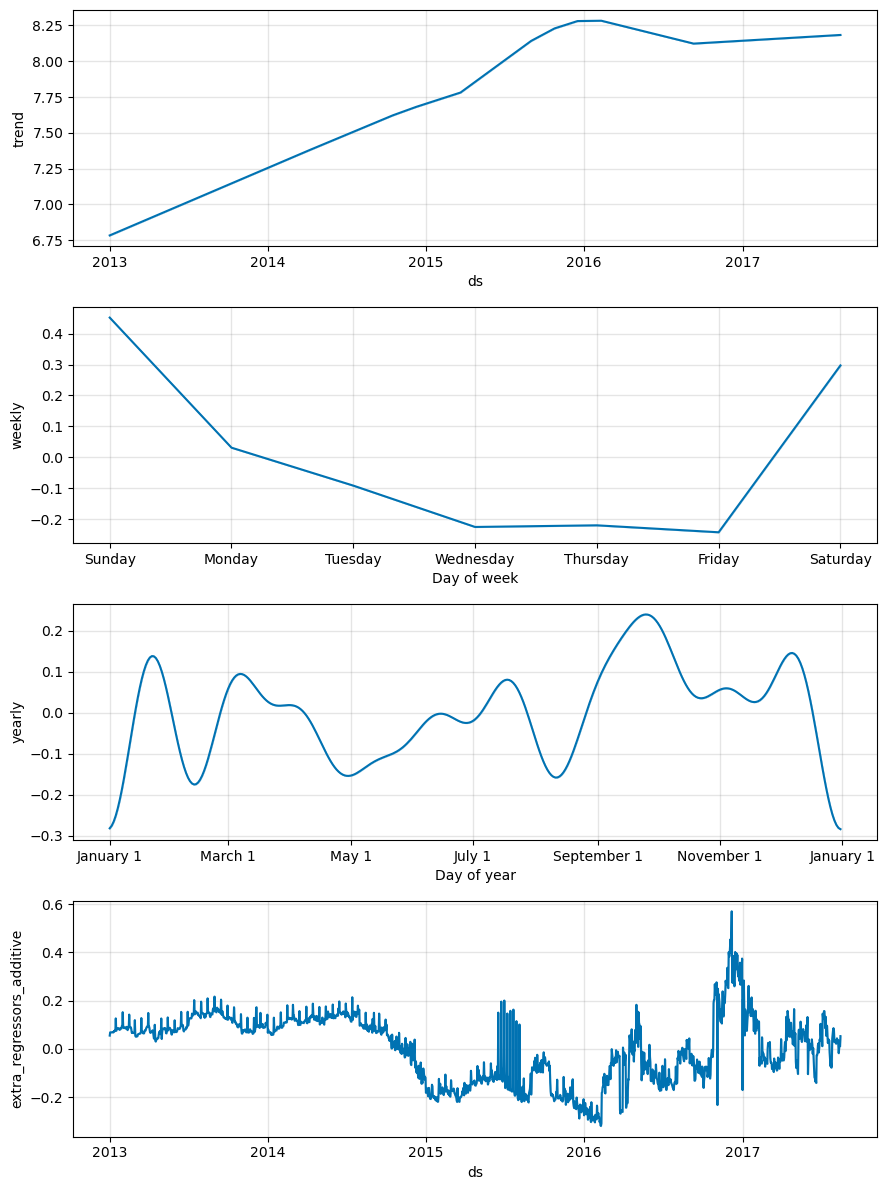

In [534]:
model.plot_components(preds)

## Create model to recursivly iterate through stores and families to pridict sales

In [544]:
#creaate a copy and check the data types
df_train_m = df_train.copy()
df_test_m = df_test.copy()

In [545]:
#rename the columns
df_train_m.rename(columns={'date':'ds','sales':'y'}, inplace=True)
df_test_m.rename(columns={'date':'ds'}, inplace=True)

In [546]:
df_train_m.y = np.log1p(df_train_m.y)

In [637]:
df_train_m.sample(10)

,ds,store_nbr,family,y,onpromotion,city,state,type,cluster,national_holiday_ind,regional_holiday_ind,local_holiday_ind,dcoilwtico,is_salary_day
104340,2013-02-28,36,PLAYERS AND ELECTRONICS,0.00,0,Libertad,Guayas,E,10,0.00,0.00,0.00,92.03,1
2513057,2016-11-10,14,DAIRY,6.14,12,Riobamba,Chimborazo,C,7,0.00,0.00,0.00,44.62,0
1016665,2014-07-26,35,BABY CARE,0.00,0,Playas,Guayas,C,3,0.00,0.00,0.00,105.68,0
1822453,2015-10-21,43,POULTRY,4.82,0,Esmeraldas,Esmeraldas,E,10,0.00,0.00,0.00,45.22,0
2001732,2016-01-31,24,HOME CARE,5.77,1,Guayaquil,Guayas,D,1,0.00,0.00,0.00,31.62,1
490056,2013-10-03,1,CELEBRATION,0.00,0,Quito,Pichincha,D,13,0.00,0.00,0.00,103.29,0
1816595,2015-10-18,3,FROZEN FOODS,6.31,0,Quito,Pichincha,D,8,0.00,0.00,0.00,45.91,0
14801,2013-01-09,24,HOME APPLIANCES,0.00,0,Guayaquil,Guayas,D,1,0.00,0.00,0.00,93.08,0
2541302,2016-11-25,7,BREAD/BAKERY,6.63,6,Quito,Pichincha,D,8,1.00,0.00,0.00,46.72,0
1349297,2015-01-29,18,PET SUPPLIES,0.00,0,Quito,Pichincha,B,16,0.00,0.00,0.00,44.12,0


In [548]:
df_test_m.sample(10)

,ds,store_nbr,family,onpromotion,city,state,type,cluster,national_holiday_ind,regional_holiday_ind,local_holiday_ind,dcoilwtico,is_salary_day
21145,2017-08-27,51,PERSONAL CARE,16,Guayaquil,Guayas,A,17,0.00,0.00,0.00,46.40,0
26687,2017-08-30,8,MAGAZINES,0,Quito,Pichincha,D,8,0.00,0.00,0.00,45.96,0
11484,2017-08-22,31,AUTOMOTIVE,0,Babahoyo,Los Rios,B,10,0.00,0.00,0.00,47.65,0
8499,2017-08-20,47,HOME CARE,7,Quito,Pichincha,A,14,0.00,0.00,0.00,47.39,0
17325,2017-08-25,45,AUTOMOTIVE,0,Quito,Pichincha,A,11,0.00,0.00,0.00,47.65,0
7323,2017-08-20,14,PRODUCE,1,Riobamba,Chimborazo,C,7,0.00,0.00,0.00,47.39,0
949,2017-08-16,35,PERSONAL CARE,19,Playas,Guayas,C,3,0.00,0.00,0.00,46.80,0
27898,2017-08-31,41,GROCERY II,0,Machala,El Oro,D,4,0.00,0.00,0.00,47.26,1
20360,2017-08-27,3,SEAFOOD,1,Quito,Pichincha,D,8,0.00,0.00,0.00,46.40,0
20270,2017-08-27,28,DAIRY,10,Guayaquil,Guayas,E,10,0.00,0.00,0.00,46.40,0


In [717]:
# get list of stores from test dataset
store_list = df_test_m.store_nbr.unique()
store_list

array([ 1, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,  2, 20, 21, 22, 23, 24,
       25, 26, 27, 28, 29,  3, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39,  4,
       40, 41, 42, 43, 44, 45, 46, 47, 48, 49,  5, 50, 51, 52, 53, 54,  6,
        7,  8,  9])

In [718]:
# get list of families from test dataset
familiy_list = df_test_m.family.unique()
familiy_list

array(['AUTOMOTIVE', 'BABY CARE', 'BEAUTY', 'BEVERAGES', 'BOOKS',
       'BREAD/BAKERY', 'CELEBRATION', 'CLEANING', 'DAIRY', 'DELI', 'EGGS',
       'FROZEN FOODS', 'GROCERY I', 'GROCERY II', 'HARDWARE',
       'HOME AND KITCHEN I', 'HOME AND KITCHEN II', 'HOME APPLIANCES',
       'HOME CARE', 'LADIESWEAR', 'LAWN AND GARDEN', 'LINGERIE',
       'LIQUOR,WINE,BEER', 'MAGAZINES', 'MEATS', 'PERSONAL CARE',
       'PET SUPPLIES', 'PLAYERS AND ELECTRONICS', 'POULTRY',
       'PREPARED FOODS', 'PRODUCE', 'SCHOOL AND OFFICE SUPPLIES',
       'SEAFOOD'], dtype=object)

In [719]:
import warnings
warnings.filterwarnings("ignore")

import logging, sys
logging.disable(sys.maxsize)

In [701]:
# iterate thorugh the lists to create a model and pridiction for each store/family

prediction_train_df = pd.DataFrame()
prediction_test_df = pd.DataFrame()


for store in store_list:
    for family in familiy_list:
        
        df_train_p = df_train_m.query("store_nbr == @store and family == @family ").copy(deep=True)
        df_test_p = df_test_m.query("store_nbr == @store and family == @family ").copy(deep=True)
    
        model = Prophet()
        model.add_regressor('dcoilwtico')
        model.add_regressor('is_salary_day')
        model.add_regressor('onpromotion')
        model.add_regressor('national_holiday_ind')
        model.add_regressor('regional_holiday_ind')
        model.add_regressor('local_holiday_ind')

        print('Fitting and predicting model for store ', store, ' and family ', family )
        model.fit(df_train_p)
        
        
        preds_train = model.predict(df_train_p)
        preds_test = model.predict(df_test_p)
        
        
        preds_train['store_nbr'] = store
        preds_test['store_nbr'] = store

        preds_train['family'] = family
        preds_test['family'] = family
        
        
        prediction_train_df= prediction_train_df.append(preds_train.copy())
        prediction_test_df= prediction_test_df.append(preds_test.copy())

        


Fitting and predicting model for store  1  and family  AUTOMOTIVE
Fitting and predicting model for store  1  and family  BEVERAGES
Fitting and predicting model for store  2  and family  AUTOMOTIVE
Fitting and predicting model for store  2  and family  BEVERAGES
Fitting and predicting model for store  3  and family  AUTOMOTIVE
Fitting and predicting model for store  3  and family  BEVERAGES


In [702]:
prediction_train_df['sales_pred'] = np.expm1(prediction_train_df[['yhat']])
prediction_test_df['sales_pred'] = np.expm1(prediction_test_df[['yhat']])

In [720]:
# get data for 2017 for store 9 beverages for plotting
predict_chart = prediction_test_df[(prediction_test_df['ds']>='2017-01-01') & (prediction_test_df['store_nbr']==9) & (prediction_test_df['family']=='BEVERAGES')].copy()
predict_hist_chart = prediction_train_df[(prediction_train_df['ds']>='2017-01-01') & (prediction_train_df['store_nbr']==9) & (prediction_train_df['family']=='BEVERAGES')].copy()
actual_chart = df_train_m[(df_train_m['ds']>='2017-01-01') & (df_train_m['store_nbr']==9) & (df_train_m['family']=='BEVERAGES')].copy()

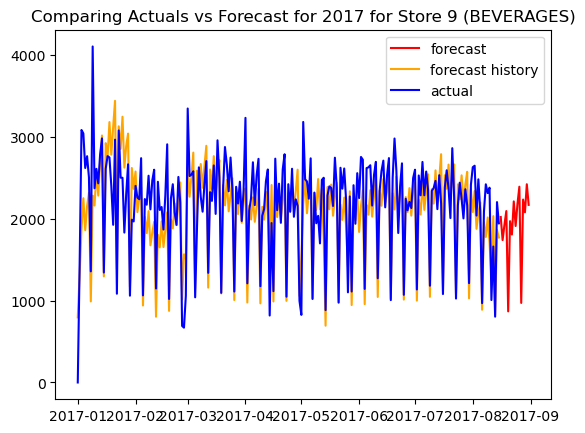

<Figure size 3500x480 with 0 Axes>

In [721]:
plt.plot(predict_chart['ds'] , predict_chart['sales_pred'], color='red' , label='forecast')
plt.plot(predict_hist_chart['ds'] , predict_hist_chart['sales_pred'], color='orange' , label='forecast history')
plt.plot(actual_chart['ds'] , np.expm1(actual_chart['y']), color='blue' , label='actual')
plt.title('Comparing Actuals vs Forecast for 2017 for Store 9 (BEVERAGES)')
plt.legend()
plt.figure().set_figwidth(35)
plt.show()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,dcoilwtico,...,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat,store_nbr,family,sales_pred
0,2017-08-16,7.71,6.96,8.29,7.71,7.71,-0.10,-0.10,-0.10,-0.12,...,-0.17,-0.17,-0.17,0.00,0.00,0.00,7.61,1,BEVERAGES,2019.52
1,2017-08-17,7.71,6.87,8.09,7.71,7.71,-0.25,-0.25,-0.25,-0.12,...,-0.17,-0.17,-0.17,0.00,0.00,0.00,7.46,1,BEVERAGES,1737.76
2,2017-08-18,7.71,6.96,8.21,7.71,7.71,-0.14,-0.14,-0.14,-0.11,...,-0.16,-0.16,-0.16,0.00,0.00,0.00,7.56,1,BEVERAGES,1924.75
3,2017-08-19,7.71,7.04,8.28,7.71,7.71,-0.06,-0.06,-0.06,-0.12,...,-0.15,-0.15,-0.15,0.00,0.00,0.00,7.65,1,BEVERAGES,2091.60
4,2017-08-20,7.71,6.15,7.38,7.71,7.71,-0.94,-0.94,-0.94,-0.12,...,-0.14,-0.14,-0.14,0.00,0.00,0.00,6.77,1,BEVERAGES,867.41


array([nan,  2.])

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,dcoilwtico,...,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat,store_nbr
1674,2017-08-02,6.42,5.81,6.96,6.42,6.42,-0.03,-0.03,-0.03,0.03,...,-0.16,-0.16,0.04,0.04,0.04,0.00,0.00,0.00,6.40,NaN
7,2013-01-08,-0.02,-0.47,0.46,-0.02,-0.02,0.02,0.02,0.02,-0.01,...,-0.04,-0.04,0.07,0.07,0.07,0.00,0.00,0.00,0.00,NaN
372,2014-01-09,2.06,1.14,2.92,2.06,2.06,-0.07,-0.07,-0.07,-0.02,...,-0.06,-0.06,0.01,0.01,0.01,0.00,0.00,0.00,1.99,NaN
259,2013-09-17,4.58,3.88,5.24,4.58,4.58,0.01,0.01,0.01,-0.04,...,-0.01,-0.01,0.11,0.11,0.11,0.00,0.00,0.00,4.59,NaN
829,2015-04-11,4.26,0.63,5.15,4.26,4.26,-1.36,-1.36,-1.36,-0.31,...,0.07,0.07,-1.27,-1.27,-1.27,0.00,0.00,0.00,2.90,NaN
727,2014-12-30,1.28,0.59,2.11,1.28,1.28,0.06,0.06,0.06,0.00,...,-0.08,-0.08,0.14,0.14,0.14,0.00,0.00,0.00,1.35,NaN
256,2013-09-14,1.74,1.07,3.08,1.74,1.74,0.33,0.33,0.33,-0.01,...,0.44,0.44,-0.08,-0.08,-0.08,0.00,0.00,0.00,2.07,NaN
588,2014-08-13,5.79,5.43,6.39,5.79,5.79,0.09,0.09,0.09,-0.03,...,0.23,0.23,-0.10,-0.10,-0.10,0.00,0.00,0.00,5.88,NaN
62,2013-03-04,0.60,-0.31,1.29,0.60,0.60,-0.13,-0.13,-0.13,-0.01,...,-0.18,-0.18,0.07,0.07,0.07,0.00,0.00,0.00,0.46,NaN
224,2013-08-13,1.31,0.77,2.09,1.31,1.31,0.08,0.08,0.08,0.05,...,-0.05,-0.05,0.14,0.14,0.14,0.00,0.00,0.00,1.39,NaN
